In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
code_root = project_root / "neuralbi_diff" / "gbi_diff"
code_root = project_root / "neuralbi_diff"
sys.path.extend([str(project_root), str(code_root)])
print(sys.path)

['/home/robin/miniconda3/envs/gbi/lib/python312.zip', '/home/robin/miniconda3/envs/gbi/lib/python3.12', '/home/robin/miniconda3/envs/gbi/lib/python3.12/lib-dynload', '', '/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages', '/home/robin/projects/lab_project/neuralgbi_diffusion', '/home/robin/projects/lab_project/neuralgbi_diffusion/neuralbi_diff']


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm

from gbi_diff.model.lit_module import Guidance
from gbi_diff.sampling.utils import load_observed_data
from gbi_diff.utils.criterion import SBICriterion
from gbi_diff.utils.plot import _pair_plot
from gbi_diff.utils.metrics import compute_distances, mse_dist
from gbi_diff.sampling.diffusion import DiffusionSampler
from gbi_diff.utils.configs.sampling_diffusion import Config
from sourcerer.simulators import TwoMoonsSimulator
from torch import nn

# specify matplotlib rc file
plt.style.use(str(project_root / ".matplotlibrc"))


/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/robin/projects/lab_project/neuralgbi_diffusion/gbi_diff/sampling/diffusion.py:204: SyntaxWarning: invalid escape sequence '\p'
  """


In [3]:
x, theta = load_observed_data("../data/two_moons_1000.pt")
dist_matrix = compute_distances(mse_dist, x, x)

Compute mse_dist distances: 100%|██████████| 1000/1000 [00:00<00:00, 16491.52sample/s]


In [4]:
res_net_guidance_ckpt = "/home/robin/projects/lab_project/neuralgbi_diffusion/results/train_guidance/two_moons/2025-03-27-14-15-40/lightning_logs/version_0/epoch=89-step=3600.ckpt"
fc_net_guidance_ckpt = "/home/robin/projects/lab_project/neuralgbi_diffusion/results/train_guidance/two_moons/2025-03-27-11-40-53/lightning_logs/version_0/epoch=94-step=3800.ckpt"
ada_net_guidance_ckpt = "/home/robin/projects/lab_project/neuralgbi_diffusion/results/train_guidance/two_moons/2025-03-27-12-08-34/lightning_logs/version_0/epoch=54-step=2200.ckpt"
guidance = Guidance.load_from_checkpoint(res_net_guidance_ckpt)

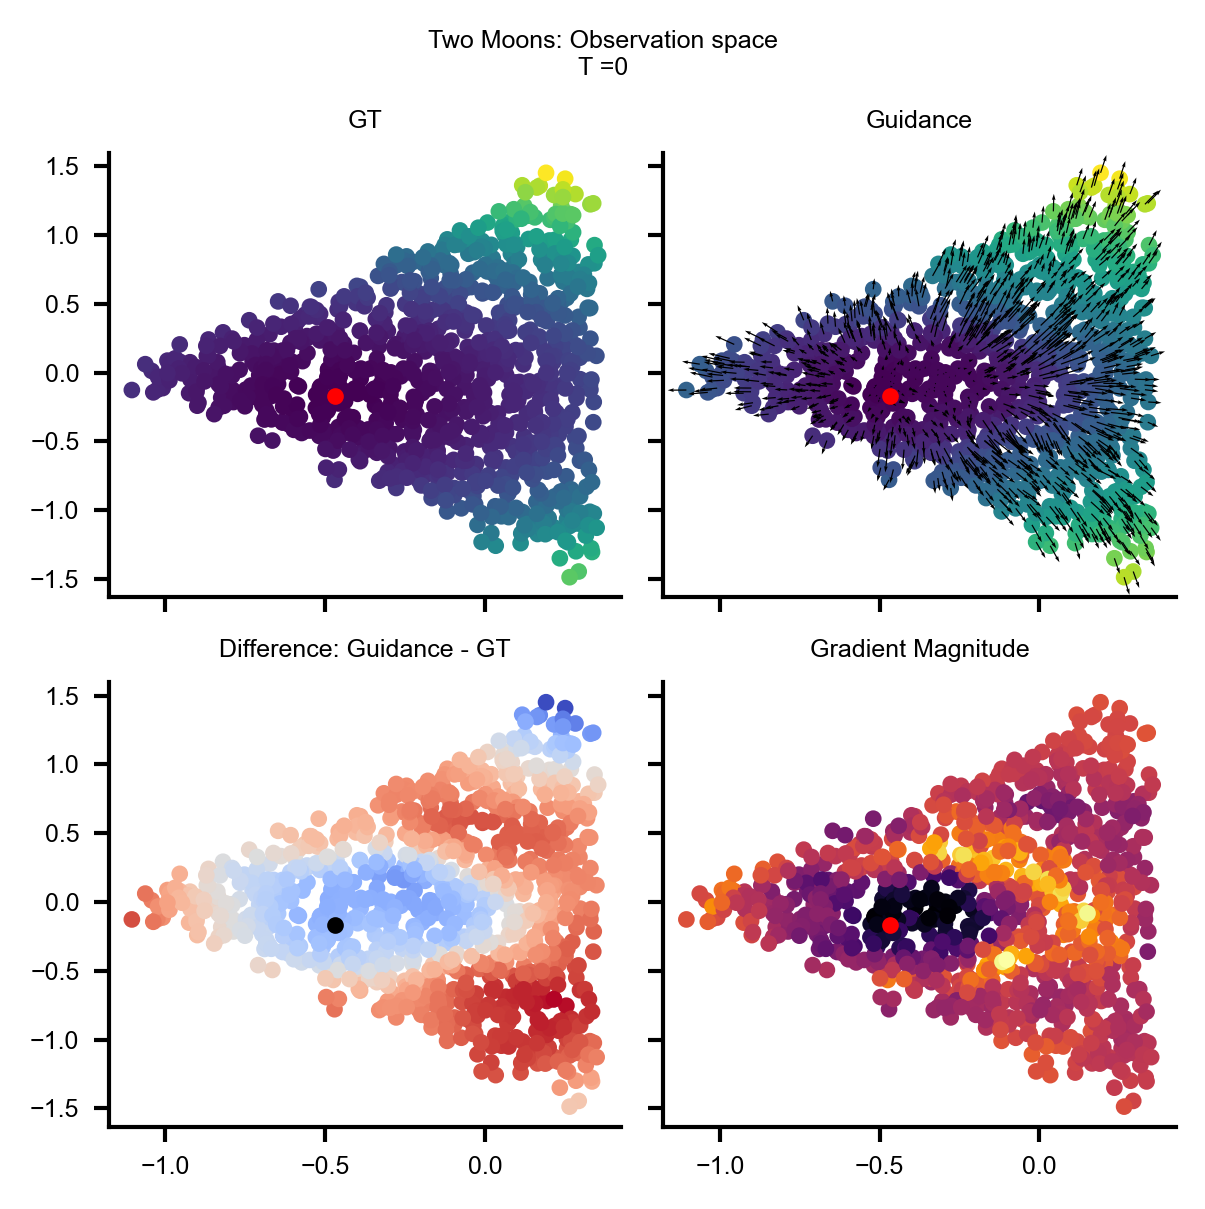

In [5]:
def plot_guidance_analytics(
    samples: Tensor,
    gt_sample: Tensor,
    gt_distance: Tensor,
    pred_distance: Tensor,
    pred_grad: Tensor,
    title: str
):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
        ncols=2, nrows=2, sharex=True, sharey=True, figsize=(4, 4)
    )
    ax1.scatter(*samples.T, c=gt_distance)
    ax1.scatter(*gt_sample, c="r")
    ax1.set_title("GT")

    ax2.scatter(*samples.T, c=pred_distance)
    ax2.quiver(*samples.T, *pred_grad.T, scale=30)
    ax2.scatter(*gt_sample, c="r")
    ax2.set_title("Guidance")

    difference = pred_distance - gt_distance
    ax3.scatter(*samples.T, c=difference - difference.mean(), cmap="coolwarm")
    ax3.scatter(*gt_sample, c="k")
    ax3.set_title("Difference: Guidance - GT")

    ax4.scatter(*samples.T, c=torch.linalg.norm(pred_grad, dim=-1), cmap="inferno")
    ax4.scatter(*gt_sample, c="r")
    ax4.set_title("Gradient Magnitude")

    fig.suptitle(title)
    fig.tight_layout()

def get_guidance_analytics(theta: Tensor, x: Tensor, guidance: Guidance, t: int = 0):
    """_summary_

    Args:
        theta (Tensor): (batch_dim, theta_dim)
        x (Tensor): (n_target, x_dim)
        guidance (Guidance): guidance function
        t (int, optional): diffusion time in index space. Defaults to 0.
    """
    time_repr = guidance.get_diff_time_repr(np.ones(len(theta)) * t)
    theta = theta.detach()
    theta.requires_grad = True
    x = x.detach()
    x.requires_grad = True
    time_repr = time_repr.detach()
    time_repr.requires_grad = True
    pred_dist = guidance.forward(theta, x[None].repeat(len(theta), 1, 1), time_repr)
    grad = torch.autograd.grad(outputs=pred_dist.sum(), inputs=(theta, x))
    theta = theta.detach()
    x = x.detach()
    pred_dist = pred_dist.detach()
    grad = [g.detach() for g in grad]

    return pred_dist, grad

idx = 9
T = 0

pred_dist, (theta_grad, x_grad) = get_guidance_analytics(theta[[idx]], x, guidance, T)
plot_guidance_analytics(x, x[idx], dist_matrix[idx], pred_dist.squeeze(), x_grad, f"Two Moons: Observation space\n{T =}")


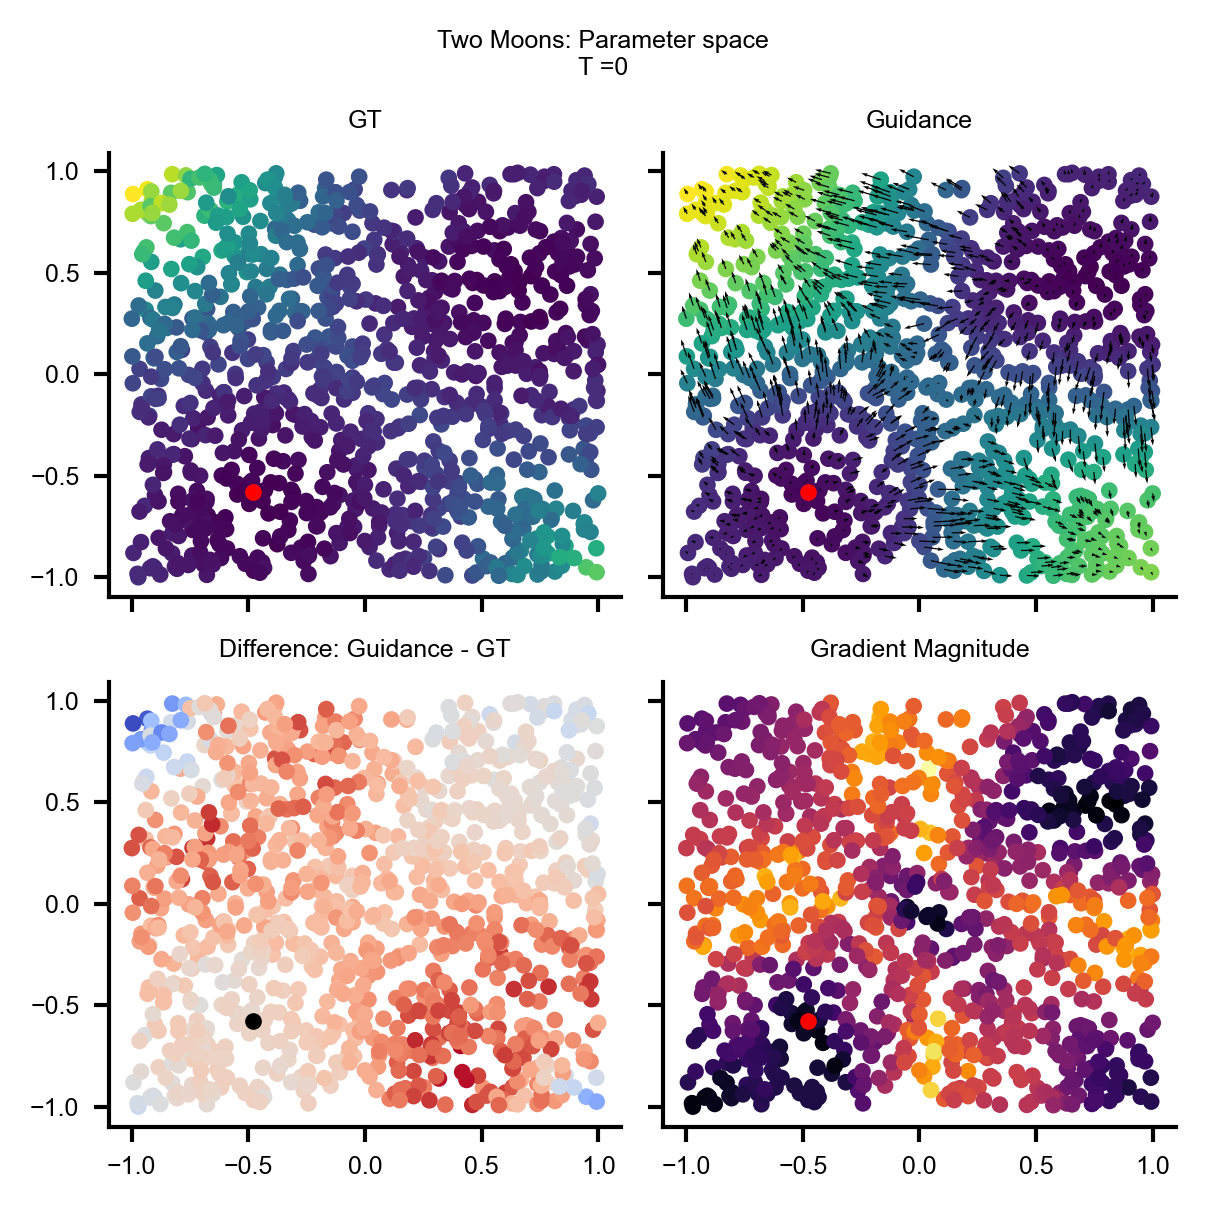

In [6]:
pred_dist, (theta_grad, x_grad) = get_guidance_analytics(theta, x[[idx]], guidance, T)
plot_guidance_analytics(theta, theta[idx], dist_matrix[idx], pred_dist.squeeze(), theta_grad, f"Two Moons: Parameter space\n{T =}")

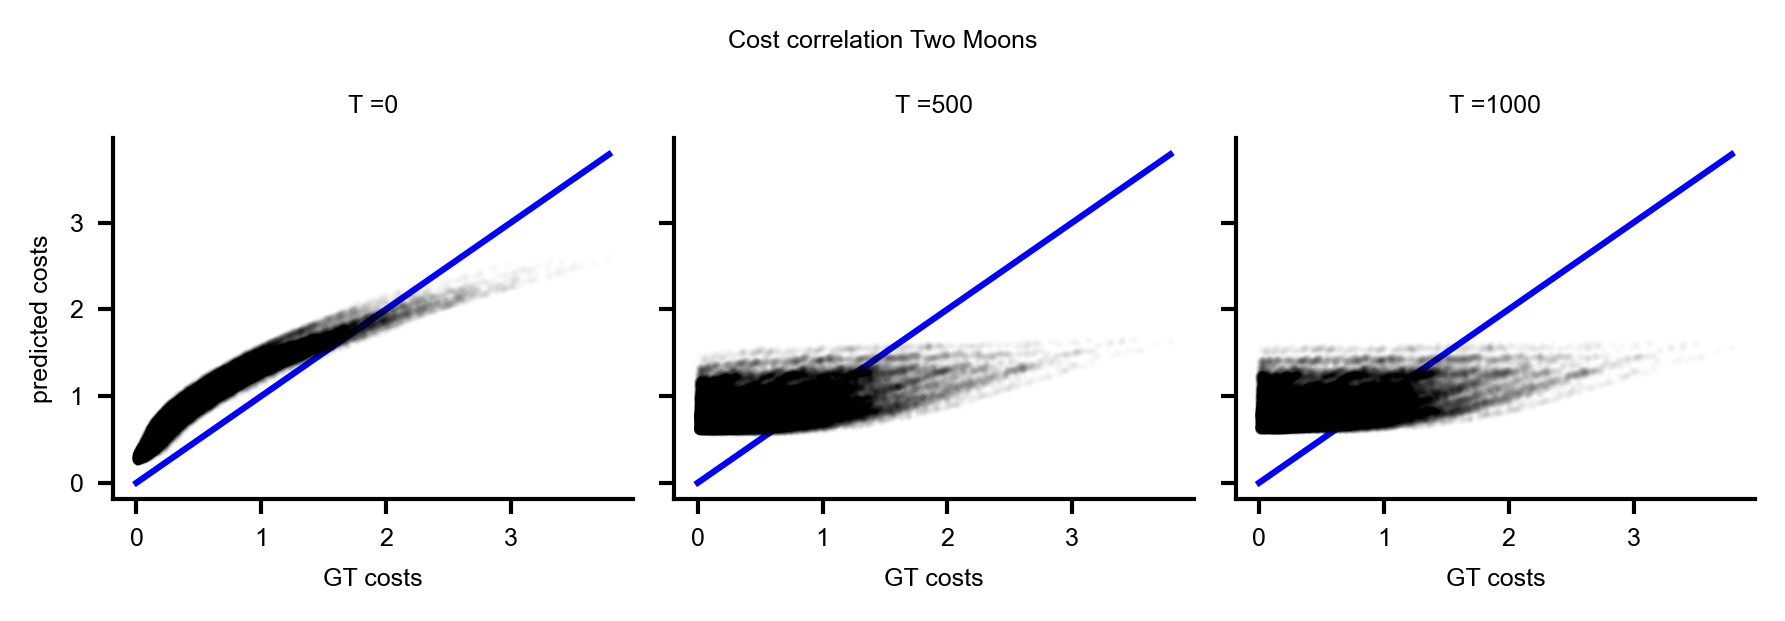

In [7]:
indices = np.arange(100)
fig, axs = plt.subplots(ncols=3, figsize=(6, 2), sharex=True, sharey=True)


for T, ax in zip([0, 500, 1000], (axs)):
    with torch.no_grad():
        time_repr = guidance.get_diff_time_repr(np.ones(len(indices)) * T)
        pred_dist = guidance.forward(theta[[indices]], x[None].repeat(len(indices), 1, 1), time_repr)

    outer = torch.maximum(dist_matrix[indices].max(), pred_dist.max())
    ax.plot([0, outer], [0, outer], color="blue", zorder=-1)
    ax.scatter(dist_matrix[indices].flatten(), pred_dist[:, :, 0].flatten(), s=1, alpha=0.01)
    ax.set_title(f"{T =}")
    ax.set_xlabel("GT costs")

axs[0].set_ylabel("predicted costs")
fig.suptitle("Cost correlation Two Moons")  
fig.tight_layout()


In [8]:
diffusion_ckpt = "/home/robin/projects/lab_project/neuralgbi_diffusion/results/train_diffusion/two_moons/2025-03-27-01-38-46/lightning_logs/version_0/epoch=99-step=4000.ckpt"

config: Config = Config.from_file("../config/sampling_diffusion.yaml")
sampler = DiffusionSampler(
    diffusion_ckpt, res_net_guidance_ckpt, config.observed_data_file, config.beta, False, extended_information=True
)

In [9]:
sampler.forward(100).detach()

Sample in observed data: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


tensor([[[-8.8650e+00, -9.8294e+00],
         [-8.6895e-01,  7.7013e-01],
         [ 1.1553e+01,  1.1511e+01],
         ...,
         [-3.1487e-01,  6.5763e-02],
         [-1.1050e+00,  8.4522e-01],
         [ 2.6522e-01, -2.5429e-01]],

        [[ 1.1382e+01,  1.1403e+01],
         [-1.3401e+01, -1.0326e+00],
         [ 1.2008e+01,  1.1770e+01],
         ...,
         [-1.1873e+01, -1.0079e+00],
         [-1.0724e+00,  8.2453e-01],
         [ 3.0247e-01, -2.3282e-01]],

        [[ 1.2550e+01,  1.2329e+01],
         [-9.8610e-01,  7.3914e-01],
         [-1.1599e+01, -2.0173e+00],
         ...,
         [-3.3222e-01, -6.6050e-03],
         [-1.3354e+01, -1.0750e+00],
         [ 3.4358e-01, -2.4074e-01]],

        ...,

        [[ 1.0839e+01,  1.0751e+01],
         [-1.3569e+01, -1.0256e+00],
         [-8.5529e+00, -9.6721e+00],
         ...,
         [-1.1855e+01, -1.0531e+00],
         [-1.3520e+01, -1.0739e+00],
         [ 2.7397e-01, -2.7262e-01]],

        [[-8.8139e+00, -1.0066e+01

In [10]:
sampler._info

{'guidance_grad': tensor([[[[-2.5841e+01, -2.7023e+01],
           [ 2.3432e+00, -1.1459e+00],
           [-1.4386e+01,  1.7477e+01],
           ...,
           [ 4.3228e+00,  1.4410e+01],
           [-1.3311e+01,  1.1821e+01],
           [-9.4711e+00,  1.4002e+00]],
 
          [[-2.8287e+01,  6.6051e+00],
           [-1.3411e+01, -7.8532e+00],
           [-1.4553e+01,  2.4067e+01],
           ...,
           [-1.4077e+01,  2.1974e+01],
           [-1.6140e+01,  1.3365e+01],
           [-4.2757e+00,  7.8405e+00]],
 
          [[-5.6176e+00,  1.3288e+01],
           [-2.1526e+01, -1.1061e+01],
           [ 3.1586e+01,  1.0439e+01],
           ...,
           [ 2.9256e+00,  1.2924e+01],
           [-4.9463e+00,  5.9270e-01],
           [ 4.3806e+00, -2.3155e+01]],
 
          ...,
 
          [[-1.6839e+01, -1.4944e+01],
           [ 4.3423e+00,  1.3109e+01],
           [ 8.6806e+00,  1.1061e+01],
           ...,
           [ 1.3218e+01,  1.6982e+00],
           [-1.6104e+01, -1.5931e+0

In [ ]:
samples = []
gammas = [10, 100, 1000]
n_samples = 1000
for gamma in gammas:
    sampler.update_gamma(gamma)
    samples.append(sampler.forward(n_samples).detach())
samples = torch.stack(samples)

Sample in observed data:   0%|          | 0/10 [00:03<?, ?it/s]
/home/robin/projects/lab_project/neuralgbi_diffusion/gbi_diff/sampling/diffusion.py:185: SyntaxWarning: invalid escape sequence '\p'
  """


KeyboardInterrupt: 

In [ ]:
x, theta = load_observed_data("../data/observed_data/two_moons_10.pt")
simulator = TwoMoonsSimulator()

fig, axs = plt.subplots(ncols=len(gammas), nrows=2, sharex="row", sharey="row", figsize=(2 * len(gammas), 4))

ax.scatter(*theta[0])
ax.scatter(*samples[:, 0].T)

sample_idx = 0
for idx, gamma in enumerate(gammas):
    axs[0, idx].scatter(*theta[sample_idx])
    time_repr = sampler._guidance_model.get_diff_time_repr(np.zeros(n_samples))
    ll = sampler._guidance_model.forward(samples[idx, :, sample_idx], x[None, [sample_idx]].repeat(n_samples, 1, 1), time_repr)
    ll = torch.exp(-gamma * ll.detach()).flatten()
    axs[0, idx].scatter(*samples[idx, :, sample_idx].T, c=ll, zorder=-1, s=1)

    axs[1, idx].scatter(*x[sample_idx])
    preds = simulator.sample(samples[idx, :, sample_idx])
    axs[1, idx].scatter(*preds.T, zorder=-1, s=1)
    gt = simulator.sample(theta[[sample_idx]].repeat(n_samples, 1))
    axs[1, idx].scatter(*gt.T, zorder=-1, s=1)
    axs[0, idx].set_title(f"{gamma =}")

axs[0, 0].set_ylabel("Parameter space")
axs[1, 0].set_ylabel("Observation space")
fig.suptitle("Two Moons sampling Specified")

NameError: name 'gammas' is not defined

In [74]:
def single_forward(
        sampler: DiffusionSampler, x_o: Tensor, n_samples: int, quiet: bool = False
    ) -> Tensor:
    """_summary_

    Args:
        x_o (Tensor): (n_simulation_features, )
        n_samples (int): how many samples you would like to create per

    Returns:
        Tensor: (n_samples, theta_dim)
    """
    # n_samples per sample in the dataset
    theta_t = torch.normal(
        0, 1, size=(n_samples, sampler.theta_dim), requires_grad=True
    )

    T = sampler._diff_model.diffusion_steps
    T = np.arange(T)[::-1]

    if sampler._normalize_data:
        _, (x_mean, x_std) = sampler._data_stats
        x_o = (x_o - x_mean) / x_std

    iterator = T
    if not quiet:
        iterator = tqdm(T, desc="Step in diffusion process", leave=True)
    
    guidance_grads = []
    diffusion_steps = []
    trajectory = [theta_t]
    for t_idx in iterator:
        beta = sampler._diff_beta_schedule.forward(t_idx)
        alpha = sampler._diff_beta_schedule.get_alphas(t_idx)
        alpha_bar = sampler._diff_beta_schedule.get_alpha_bar(t_idx)

        time_repr = sampler._diff_model.get_diff_time_repr(np.array([t_idx]))
        time_repr = time_repr.repeat(n_samples, 1)
        
        with torch.no_grad():
            diffusion_step = sampler._diff_model.forward(theta_t.clone(), time_repr)
            diffusion_step = diffusion_step.detach()
        guidance_grad = sampler.get_log_boltzmann_grad(theta_t.clone(), x_o, time_repr)
        guidance_grad = guidance_grad.detach()

        z = torch.normal(0, 1, size=theta_t.shape)
        z = torch.sqrt(beta) * z if t_idx > 0 else 0

        theta_t = (1 / torch.sqrt(alpha)) * (
            theta_t
            - (1 - alpha) / torch.sqrt(1 - alpha_bar) * diffusion_step
            + beta * guidance_grad
        ) + z

        guidance_grads.append(guidance_grad)
        diffusion_steps.append(diffusion_step)
        trajectory.append(theta_t.clone())
        del diffusion_step
        del guidance_grad
        del time_repr

    if sampler._normalize_data:
        (theta_mean, theta_std), _ = sampler._data_stats
        theta_t = theta_t * theta_std + theta_mean

    guidance_grads = torch.stack(guidance_grads) 
    diffusion_steps = torch.stack(diffusion_steps) 
    trajectory = torch.stack(trajectory) 

    return theta_t, guidance_grads, diffusion_steps, trajectory

sample_idx = 3
sampler.update_gamma(1000)
samples = single_forward(sampler, sampler.x_o[sample_idx], 1000)[0]

Step in diffusion process: 100%|██████████| 1000/1000 [00:04<00:00, 218.01it/s]


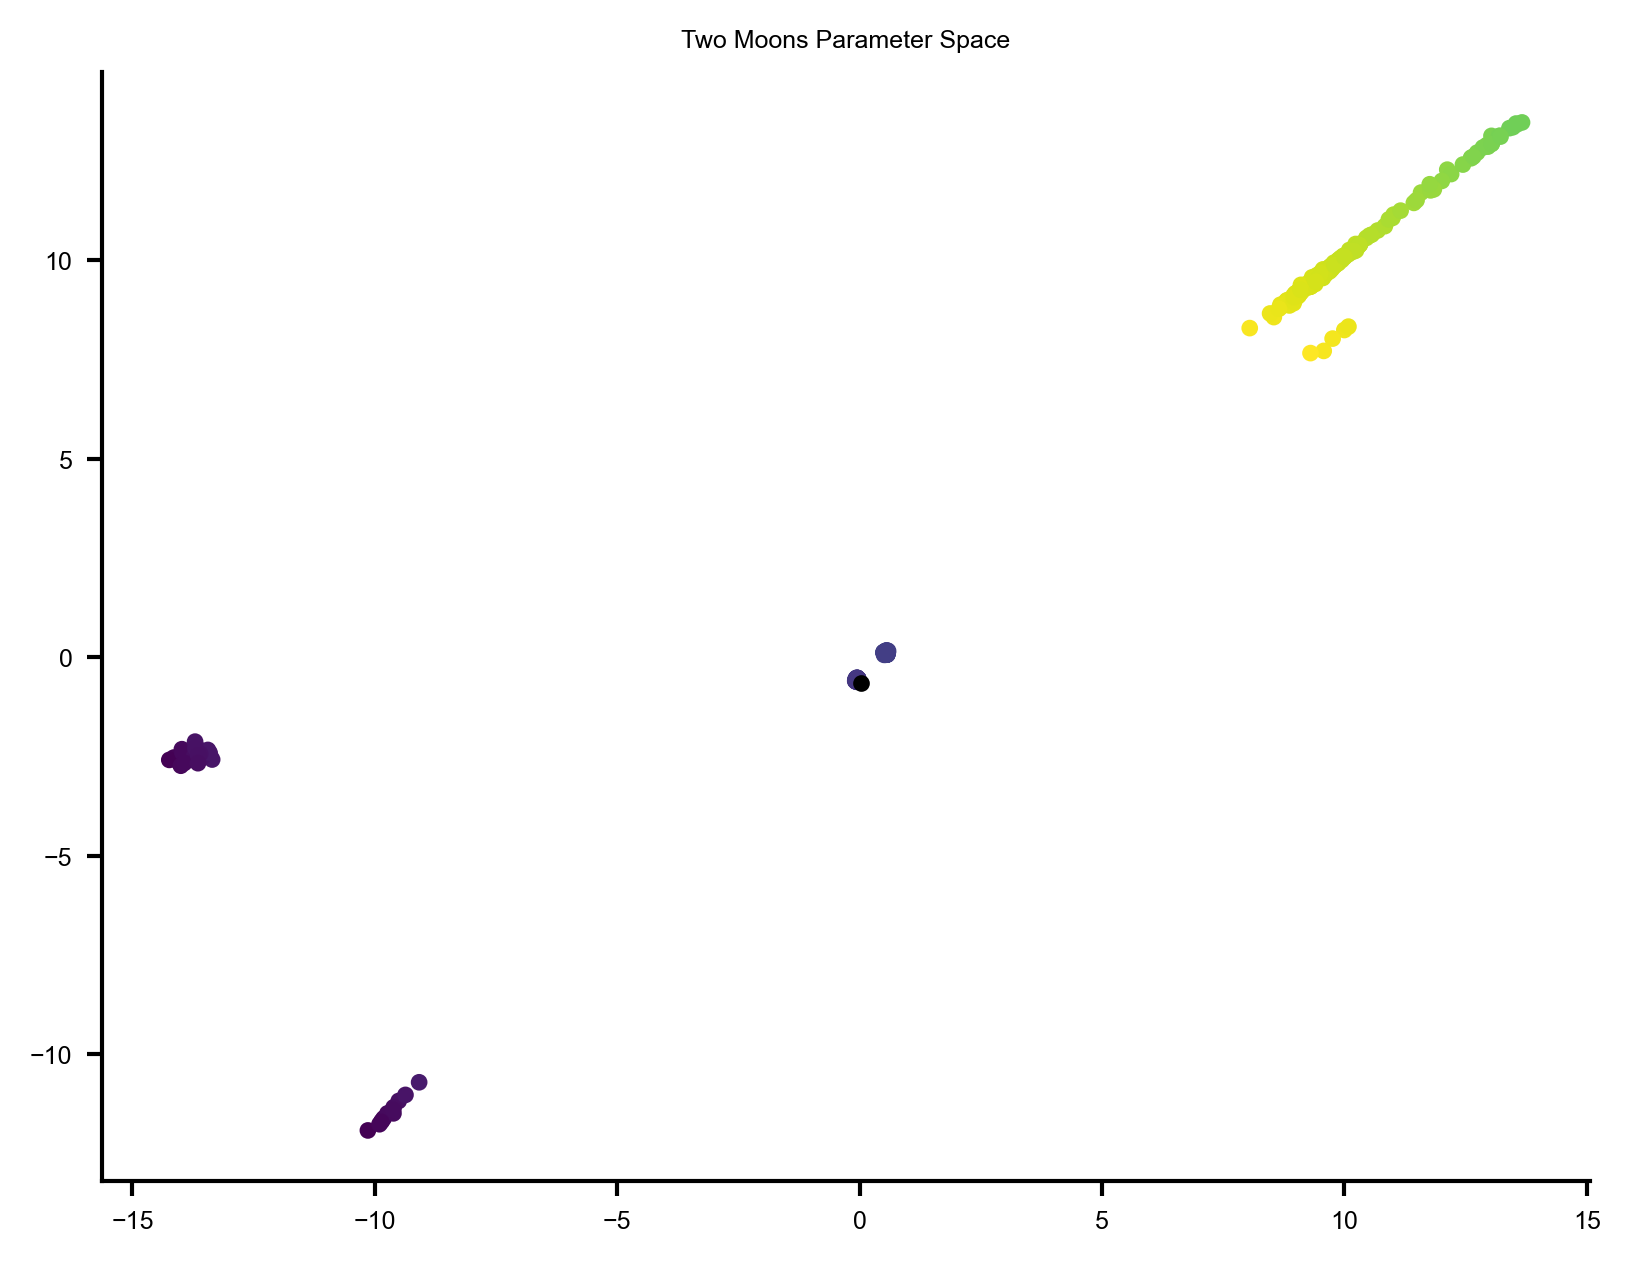

torch.Size([1000, 2])


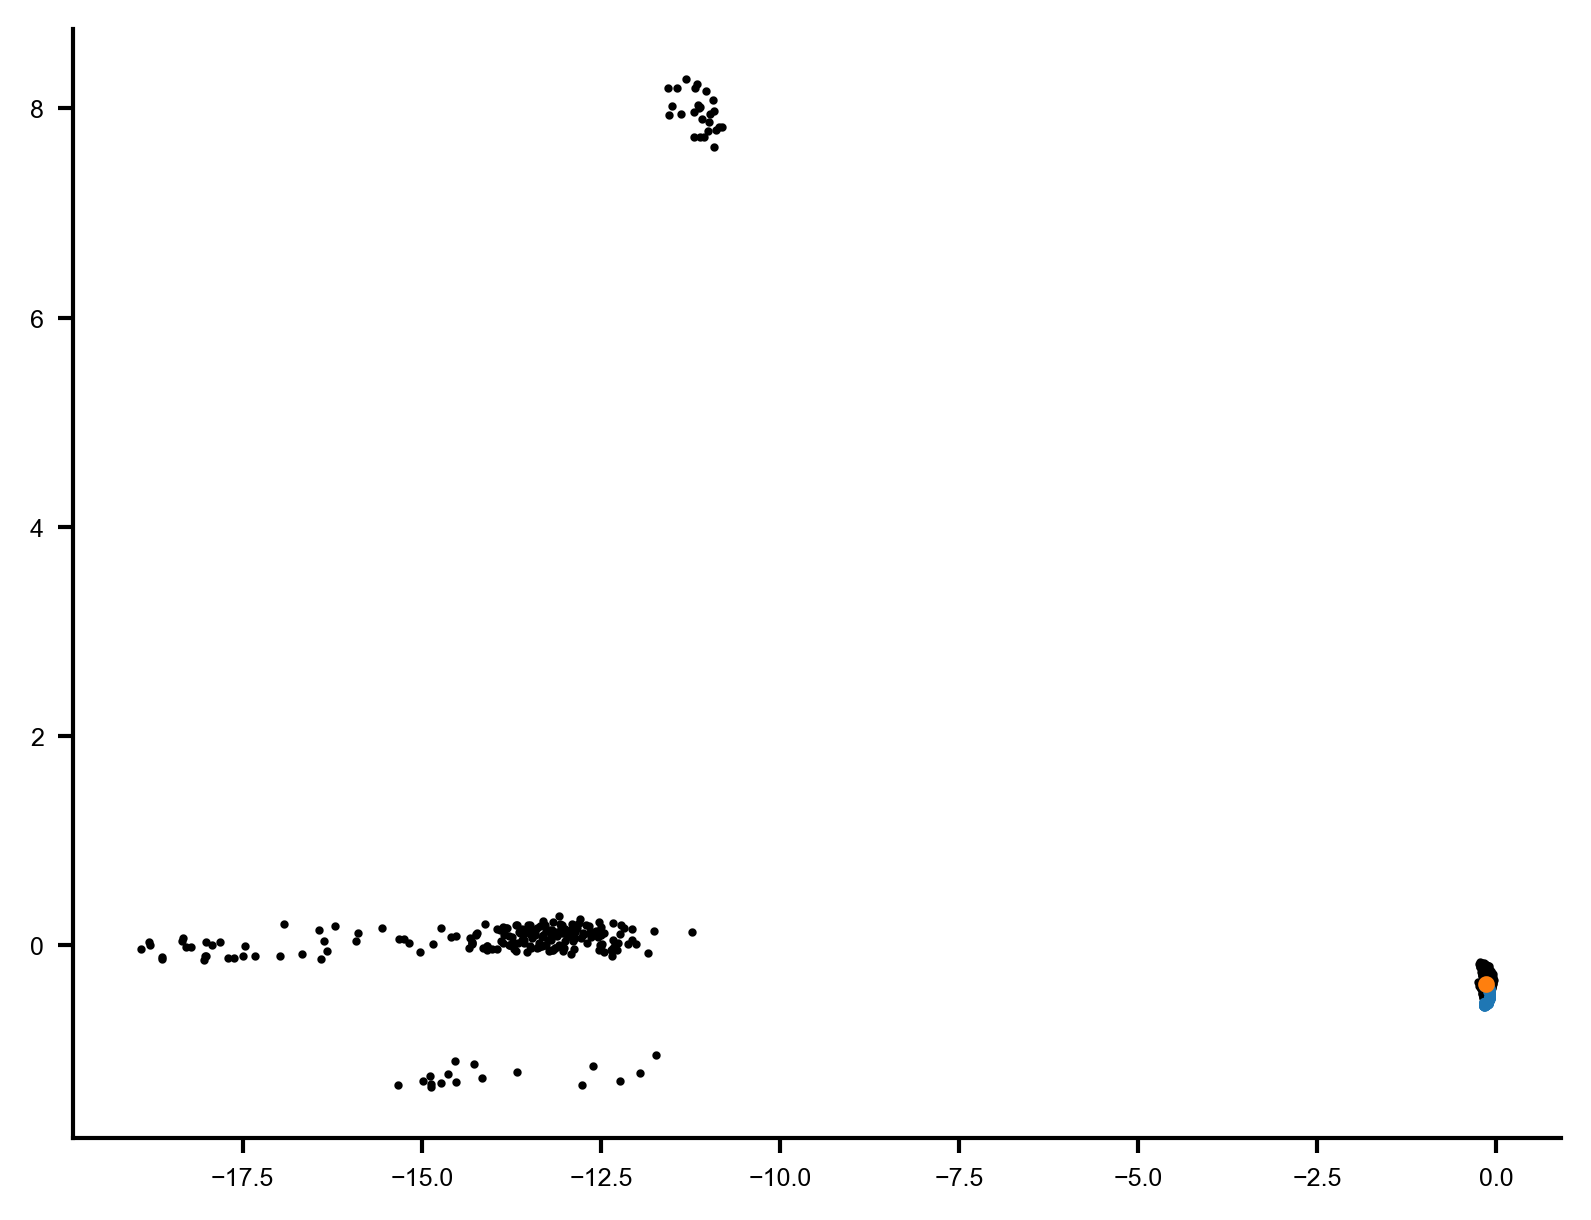

In [157]:
samples = samples.detach()
time_repr = sampler._diff_model.get_diff_time_repr(np.zeros(len(samples)))
ll = sampler._guidance_model.forward(samples, sampler.x_o[None, [sample_idx]].repeat(len(samples), 1, 1), time_repr).detach()
# grad = sampler.get_log_boltzmann_grad(samples, sampler.x_o, time_repr).detach()
plt.scatter(*samples.T.detach(), c=ll)
plt.scatter(*sampler.theta_o[sample_idx])
# plt.quiver(theta_t[:, 0], theta_t[:, 1], *grad.T)
plt.title("Two Moons Parameter Space")
plt.show()

posterior_samples = TwoMoonsSimulator().sample(samples)
print(posterior_samples.shape)
plt.scatter(*posterior_samples.T, s=1)
gt = TwoMoonsSimulator().sample(sampler.theta_o[[sample_idx]].repeat(len(samples), 1))
plt.scatter(*gt.T, s=1)
plt.scatter(*sampler.x_o[sample_idx])
plt.show()


In [ ]:
guidance_grads = []
diffusion_steps = []
trajectory = []
for idx, x_o in enumerate(sampler.x_o):
    _, a, b, c = single_forward(sampler, x_o, n_samples)
    guidance_grads.append(a)
    diffusion_steps.append(b)
    trajectory.append(c)

guidance_grads = torch.stack(guidance_grads).detach()
diffusion_steps = torch.stack(diffusion_steps).detach()
trajectory = torch.stack(trajectory).detach()

# (x_o, diff_time, samples, theta_dim)

Step in diffusion process: 100%|██████████| 1000/1000 [00:04<00:00, 219.82it/s]


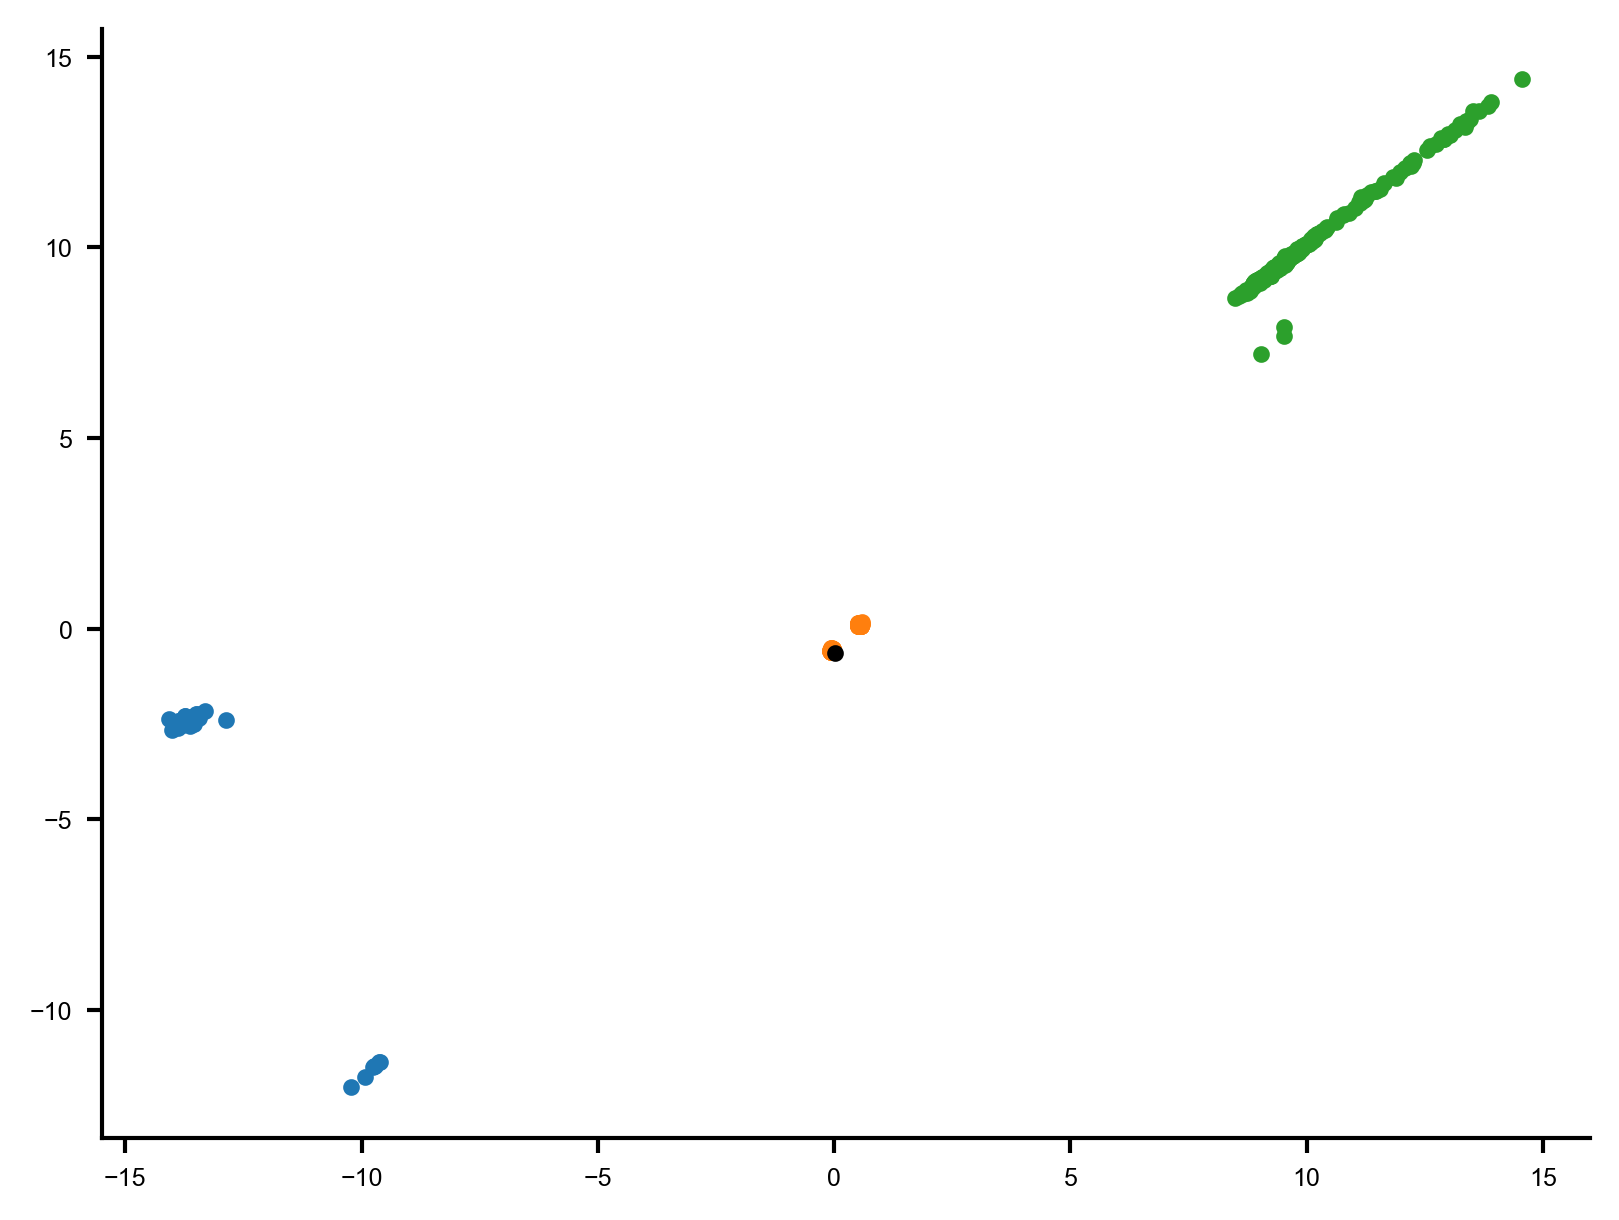

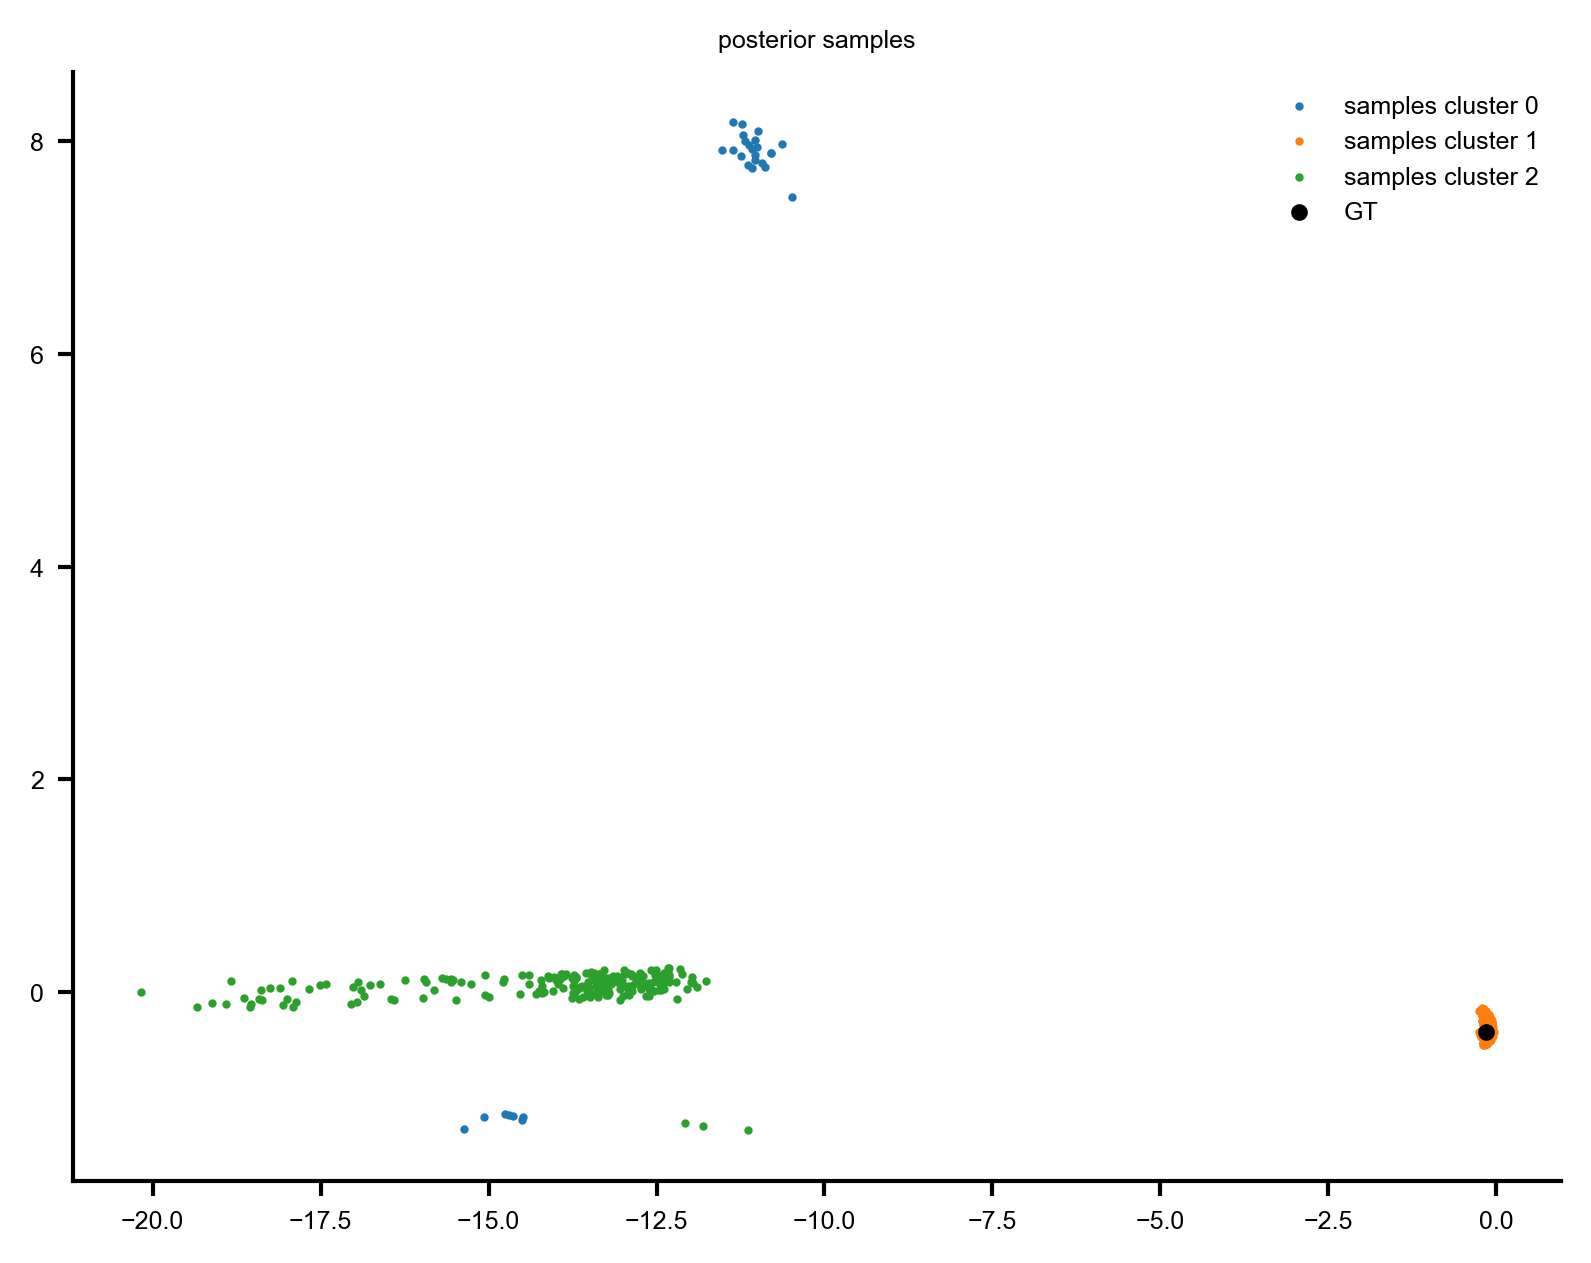

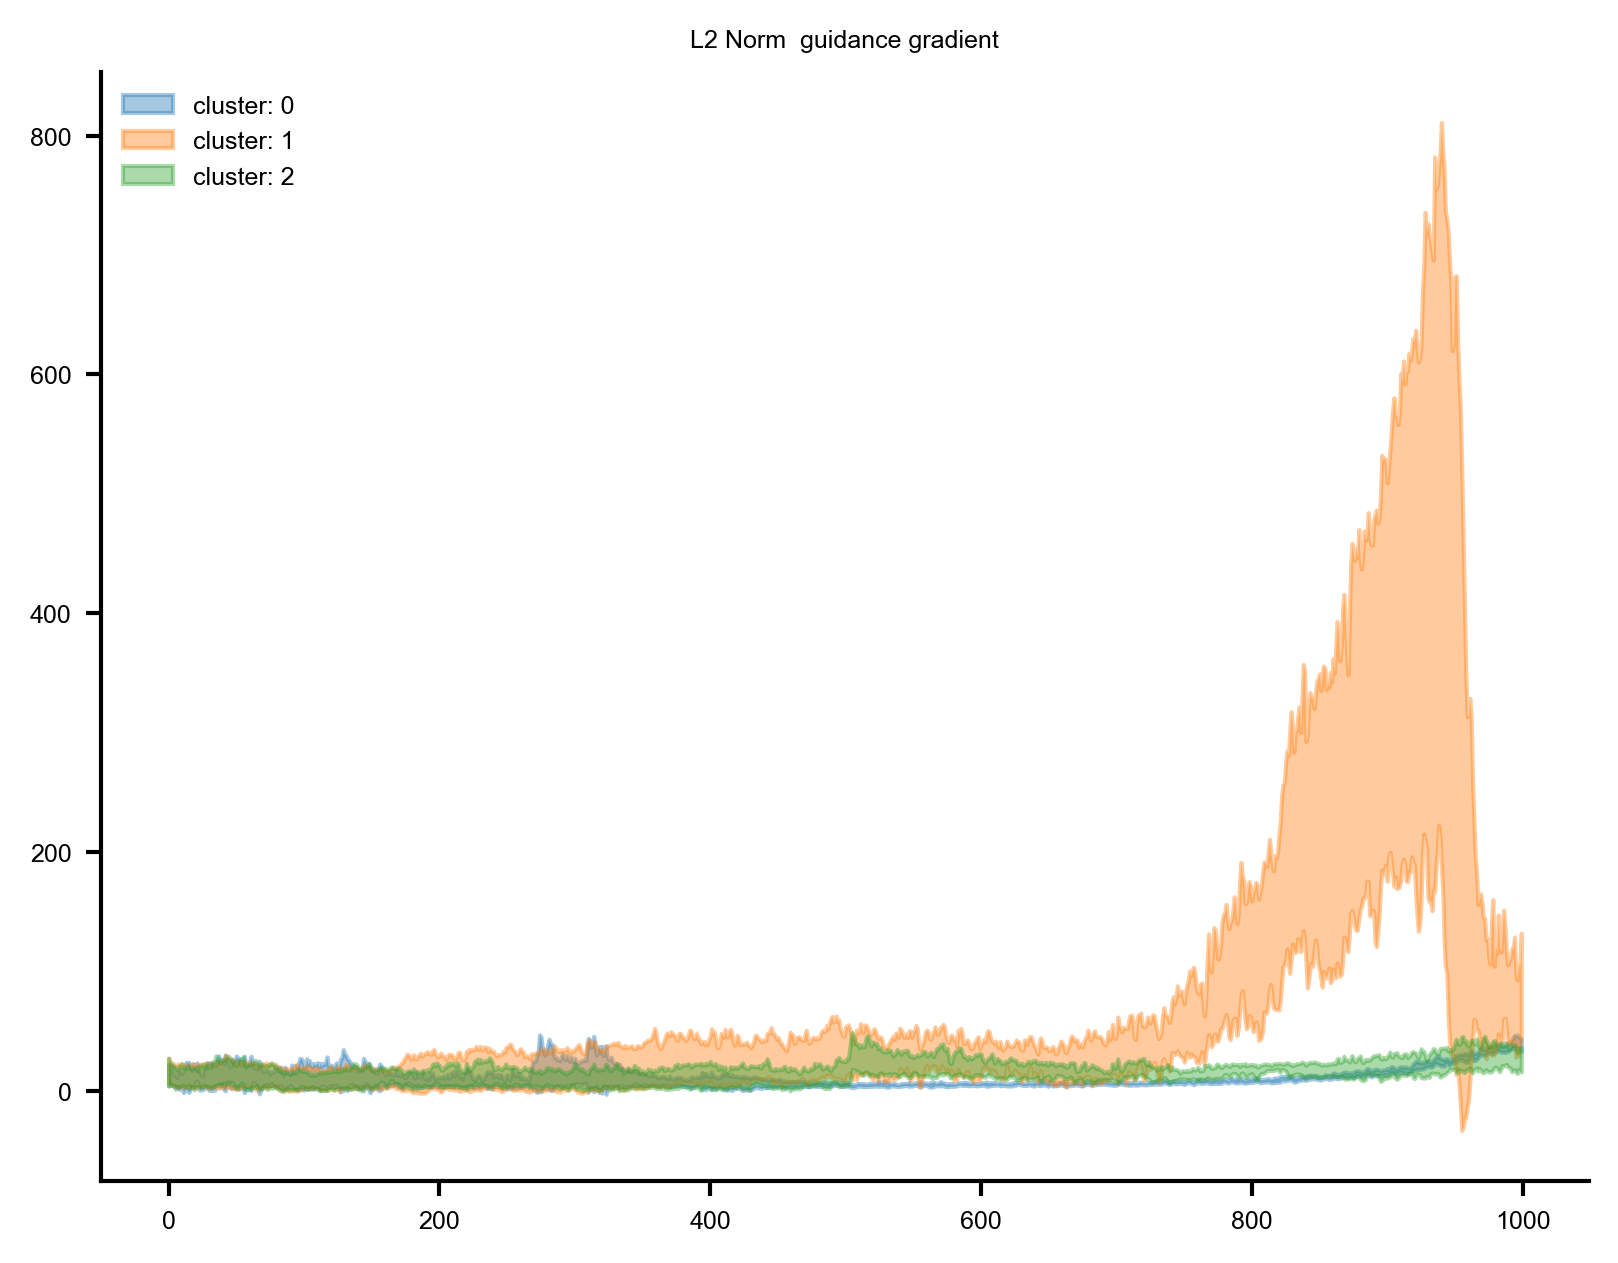

In [137]:
import matplotlib as mpl
from sklearn.cluster._kmeans import KMeans

colors_tab10 = mpl.colormaps["tab10"]
colors_tab20 = mpl.colormaps["tab20"]

sample_idx = 3
labels = KMeans(3).fit_predict(trajectory[sample_idx, -1])
for i in range(3):
    plt.scatter(*trajectory[sample_idx, -1, labels == i].T, color=colors_tab10(i))
plt.scatter(*sampler.theta_o[sample_idx])
plt.show()

plt.title("posterior samples")
for i in range(3):
    posterior_samples = TwoMoonsSimulator().sample(
        trajectory[sample_idx, -1, labels == i]
    )
    plt.scatter(*posterior_samples.T, s=1, color=colors_tab10(i), label=f"samples cluster {i}")
plt.scatter(*sampler.x_o[sample_idx], label="GT")
plt.legend()
plt.show()


guidance_stats = torch.linalg.norm(guidance_grads[sample_idx], dim=-1)
diff_stats = torch.linalg.norm(diffusion_steps[sample_idx], dim=-1)
plt.title("L2 Norm  guidance gradient")
for i in range(3):
    guidance_label_stats = guidance_stats[:, labels == i]
    diff_label_stats = diff_stats[:, labels == i]
    plt.fill_between(
        range(1000),
        guidance_label_stats.mean(dim=-1) - guidance_label_stats.std(dim=-1),
        guidance_label_stats.mean(dim=-1) + guidance_label_stats.std(dim=-1),
        color=colors_tab20(2 * i),
        alpha=0.4,
        label=f"cluster: {i}"
    )
plt.legend()
    # plt.fill_between(
    #     range(1000),
    #     diff_stats.mean(dim=-1) - diff_stats.std(dim=-1),
    #     diff_stats.mean(dim=-1) + diff_stats.std(dim=-1),
    #     color=colors_tab20(2 * i + 1),
    #     alpha=0.4,
    # )
    

# for i in range(10):
#     stats = torch.linalg.norm(guidance_grads[i], dim=-1)
#     # print(torch.max(stats, dim=-1).values)
#     # plt.plot(torch.max(stats, dim=-1).values, color=colors(i))
#     plt.plot(stats, color=colors(i), alpha=0.002, linewidth=1)
#     # plt.fill_between(torch.arange(1000), stats.mean(dim=-1), stats.std(dim=-1), alpha=0.4, color=colors(i))
#     break


Text(0.5, 1.0, 'Step size')

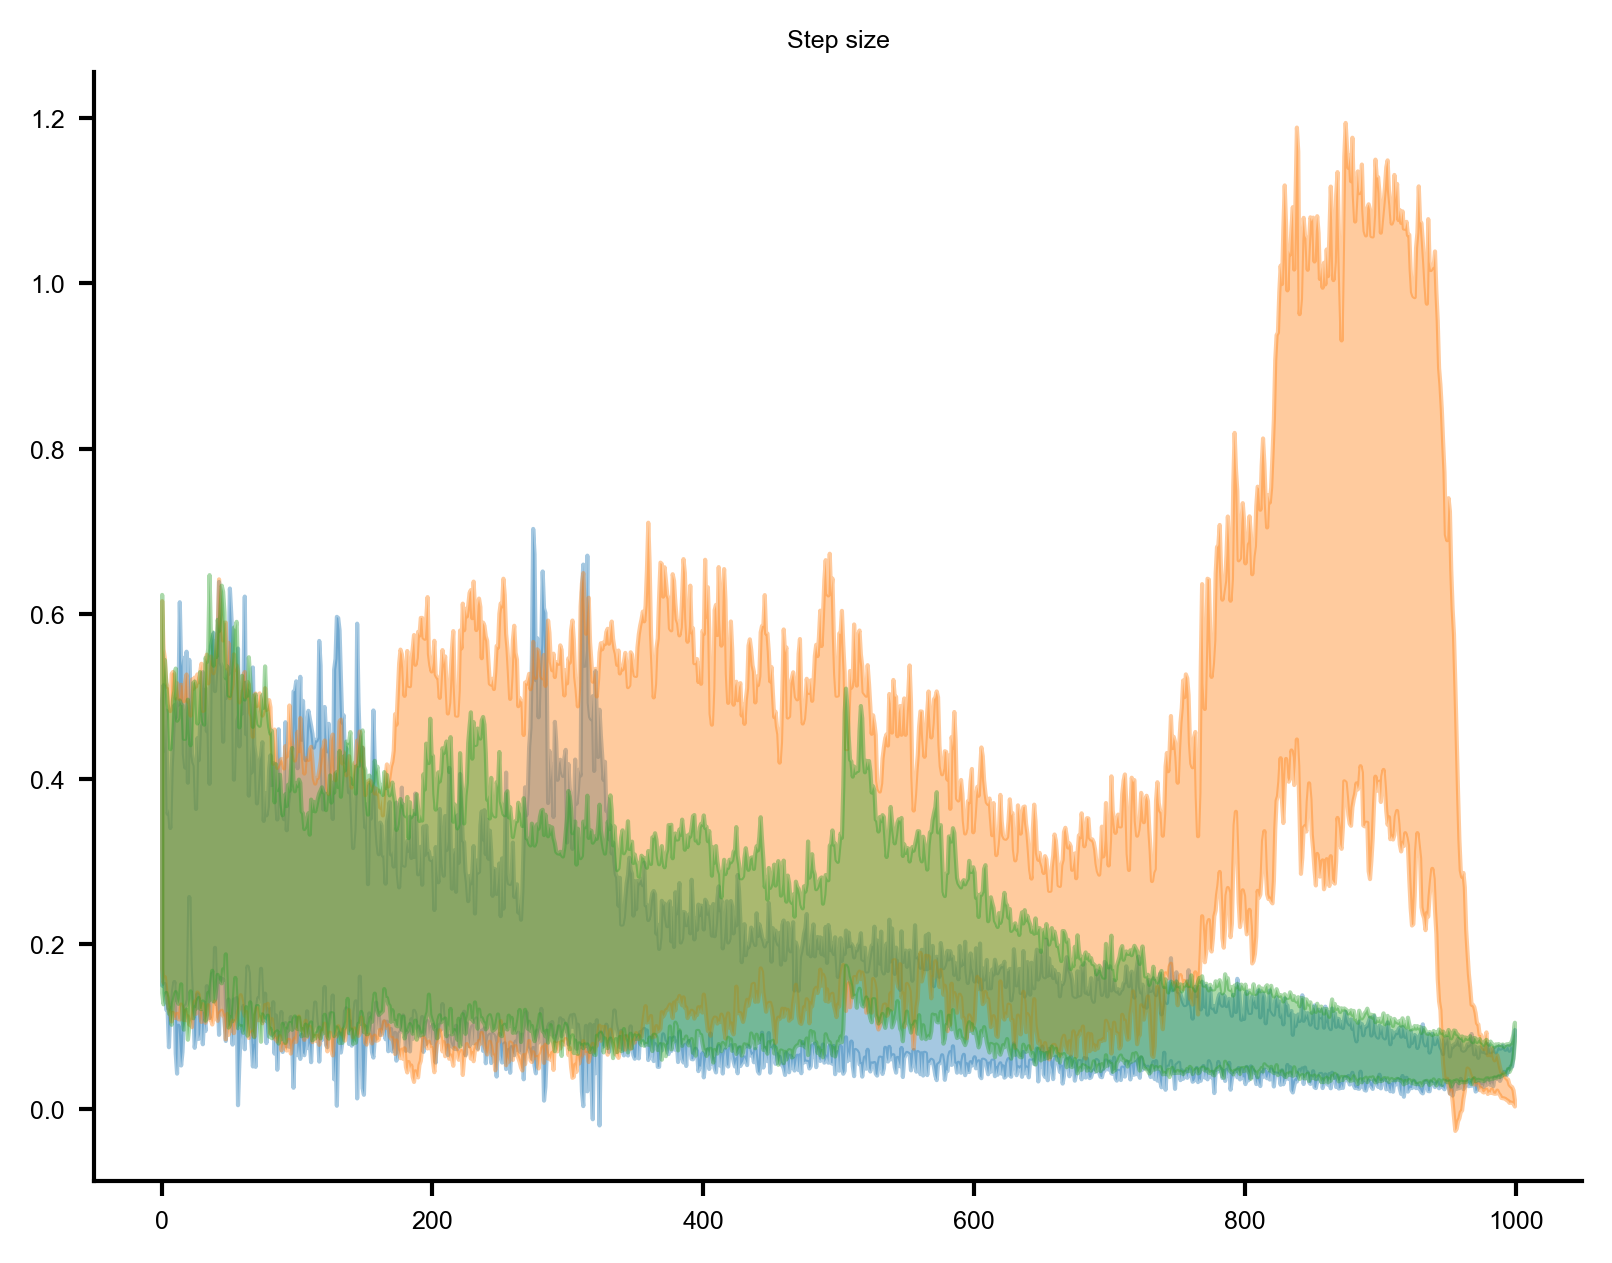

In [146]:

for i in range(3):
    label_stats = torch.linalg.norm(torch.diff(trajectory[sample_idx], dim=0), dim=-1)[:, labels == i]
    plt.fill_between(
        range(1000),
        label_stats.mean(dim=-1) - label_stats.std(dim=-1),
        label_stats.mean(dim=-1) + label_stats.std(dim=-1),
        color=colors_tab10(i),
        alpha=0.4,
        label=f"cluster: {i}"
    )
plt.title("Step size")

Text(0.5, 1.0, 'Change in directory')

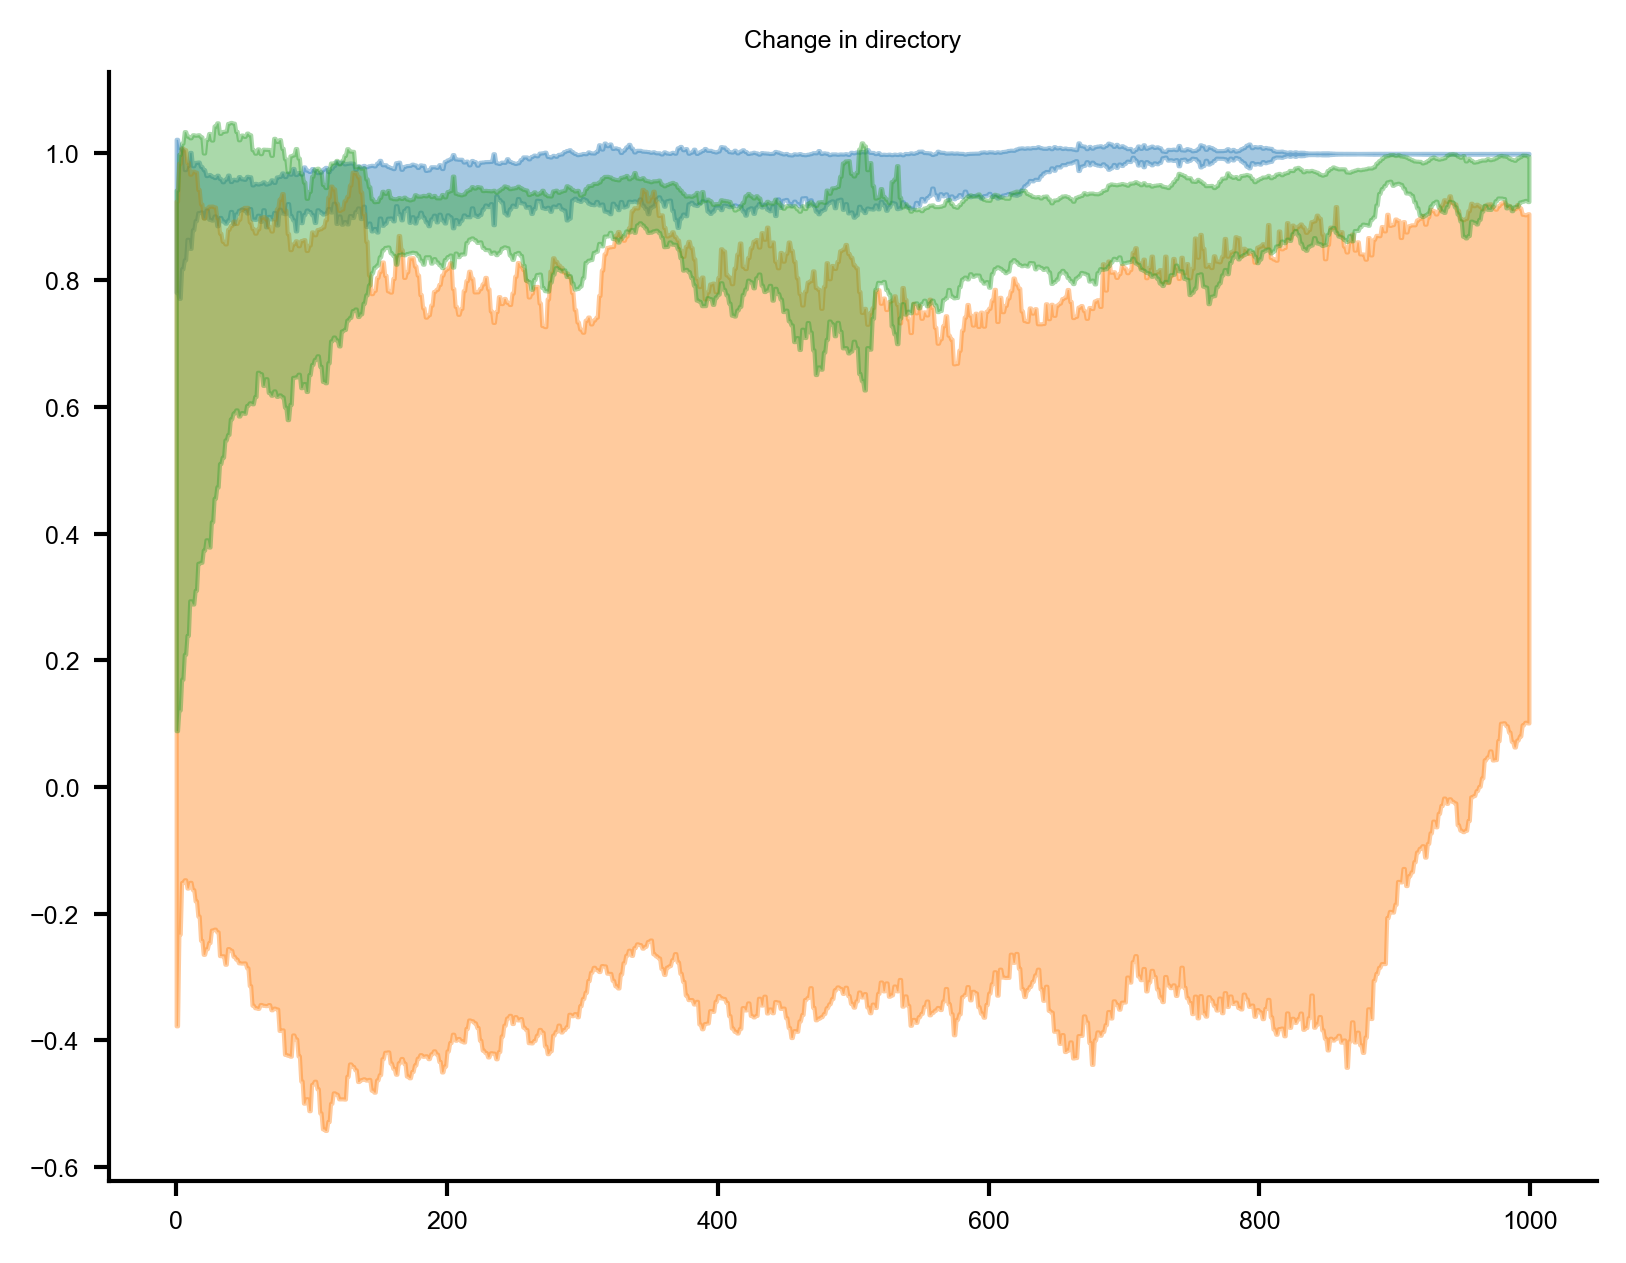

In [156]:
repeats = torch.repeat_interleave(trajectory[sample_idx], 2, dim=0).reshape(2, 1001, 1000, 2)
diff = torch.sum(repeats[0, :-1] * repeats[1, 1:], dim=-1) / torch.linalg.norm(repeats[0, :-1], dim=-1) / torch.linalg.norm(repeats[1, 1:], dim=-1)
for i in range(3):
    label_stats = diff[:, labels == i]
    plt.fill_between(
        range(1000),
        label_stats.mean(dim=-1) - label_stats.std(dim=-1),
        label_stats.mean(dim=-1) + label_stats.std(dim=-1),
        color=colors_tab10(i),
        alpha=0.4,
        label=f"cluster: {i}"
    )

plt.title("Change in directory")
